# Bittensor Consensus Mechanism 

Approach:

1. We measure 'inflation': The vector I = W^(tr) * S which determines the amount of inflation distributed to peers at the next iteration (block). 

1. We measure 'votes': A peer votes by assigning a weight w_i_j, in W, between peer i and peer j, i being the voter and j being the receiver. We tally votes into a voting matrix: V = tanh( temp * (W - kappa) ), given a choosen threshold (kappa) on the weights w_i_j, and the tanh function which takes the values onto the range (-1, 1). This way a non-vote is roughly counted as -1 and a vote is counted as 1.

1. We measure 'consensus': The difference between votes and non-votes, weighted by stake: C = tanh( transpose(V) * S ). The inner term, transpose(V) * S, at position i, is positive iff more than 50% of the stake has voted for peer i. After application of the tanh(inner), this value is on range -1, 1 where C_i is close to -1 iff less than 50% of the stake has voted for peer i and 1 otherwise.

1. We measure 'loss': The difference between the amount of inflation distributed towards peers with less than 50% of stake-weighted-votes, and those that are voted on by greater than 50% of the stake-weighted-votes: I * C. The loss is positive if the majority of stake is being distributed towards peers which are less than 50% stake-weighted in the network and negative otherwise.

1. We compute 'balance': A directional vector B, the gradient of the loss with respect to the stake vector, dl/dS. 

1. We update the stake vector given the gradient, 'B', to balance the network. S(t+1) = S(t) - alpha * B.

Discussion:

The gradient of the stake with respect to the loss a.k.a 'B', takes the stake vector in a direction towards a network where the votes have reached a form of consensus. At this point, the majority of voting power has 'agreed' with itself by voting on peers which are attaining the majority of inflation. Put another way, it is a point where majority-trusted peers attain majority-inflation.

There are two immediate effects of the described algorithm. 

1. Peers which are staking in the network but are diverging from the majority will be punished. In other words, there is incentive to 'agree' with the rest of the network. Failure to do so will ensure the gradient term 'slashes' your stake. Conversely, if you are "agreeing" with the super majority, then you will be rewarded by the gradient update.

1. A peer which is not staking, a producer peer, (being voted on) will be highly rewarded for reaching a consensus point (being trusted greatly) by the majority.




In [235]:
! pip3 install torch
! pip3 install matplotlib
! pip3 install sklearn
! pip3 install scipy

In [365]:
import torch
import matplotlib.pyplot as plt
from scipy.sparse import random
from sklearn.preprocessing import normalize

def random_weight_matrix( n, density ):
    rows = []
    for _ in range( n ):
        row_i = random(1, n, density=density).A # Each row has density_A
        row_i = normalize(row_i, axis=1, norm='l1') # Each row sums to 1.
        rows.append(row_i)
    assert np.shape(row_i)[1] == n
    assert np.isclose(np.sum(row_i), 1.0, 0.001)
    
    W = np.concatenate(rows)
    assert np.shape(W)[0] == n and np.shape(W)[1] == n
    return torch.tensor(W, dtype=torch.float32, requires_grad=True)

def random_stake_vector( n ):
    S = np.random.uniform(0, 1, size=(n, 1))
    S = (S / S.sum())
    S = np.reshape(S, [1, n])
    S = np.transpose(S)
    return torch.tensor(S, dtype=torch.float32, requires_grad=True)

def compute_inflation( W, S ):
    I = torch.matmul(torch.transpose(W, 0,1), S) / torch.sum(S)
    return I

def compute_votes( W, voting_threshold, voting_temp ):
    V = torch.tanh( voting_temp * (W - voting_threshold) )
    return V

def compute_consensus( V, S, temp ):
    inner_term = -torch.matmul(torch.transpose(V, 0, 1), S)
    C = torch.tanh( inner_term * temp )
    return C       

def compute_loss( I, C ):
    loss = -torch.dot(torch.flatten(I), torch.flatten(C))
    return loss

def compute_balance( loss, S ):
    loss.backward()
    return S.grad


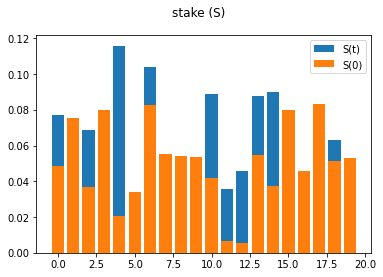

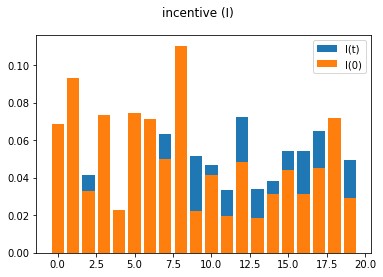

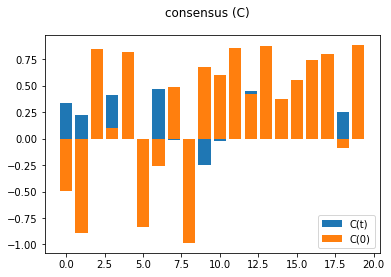

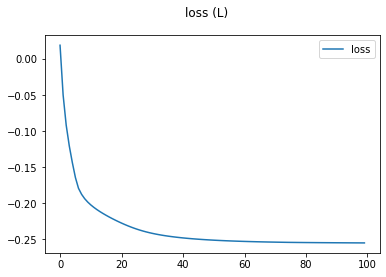

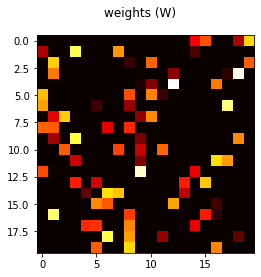

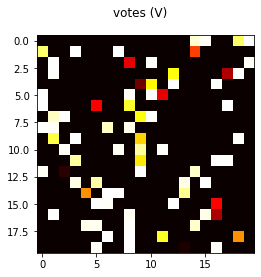

In [370]:
# Turn on print.
debug = False

# Hyperparams.
n = 20
density = 0.2
voting_temp = 10
voting_threshold = 1/(2*n)
consensus_temp = 10
alpha = 0.01

# Initial Chain stake/weights 
S = random_stake_vector( n ); 
if debug: print('\nStake (S):\n', S)
W = random_weight_matrix( n, density );
if debug: print('\nWeights (W):\n', W)
    
# Iterate over blocks.
n_steps = 100
step_losses = []
for step in range(n_steps):
    
    # Inflation.
    # We measure 'inflation': The vector I = W^(tr) * S which determines the amount of inflation distributed to peers at the next iteration (block).
    I = compute_inflation( W, S ) 
    if debug: print ('\nInflation (I):\n', I)
        
    # We measure 'votes': A peer votes by assigning a weight w_i_j, in W, between peer i and peer j, i being the voter and j being the receiver. 
    # We tally votes into a voting matrix: V = tanh( temp * (W - kappa) ), given a choosen threshold (kappa) on the weights w_i_j, 
    # and the tanh function which takes the values onto the range (-1, 1). This way a non-vote is roughly counted as -1 and a vote is counted as 1.
    V = compute_votes( W, voting_threshold, voting_temp )
    if debug: print('\nVotes (V):\n',V)

    # We measure 'consensus': The sum of inward votes weighted by stake: C = tanh( transpose(V) * S ). 
    # The inner term, transpose(V) * S, at position i, is positive iff more than 50% of the stake has voted for peer i. 
    # After application of the tanh(inner), this value is on range -1, 1 where C_i is close to -1 iff less than 
    # 50% of the stake has voted for peer i and 1 otherwise.
    C = compute_consensus( V, S, consensus_temp )
    if debug: print('\nConsensus (CT):\n', C)

    # We measure 'loss': The difference between the amount of inflation distributed towards peers with less than 50% of stake-weighted-votes,
    # and those that are voted on by greater than 50% of the stake-weighted-votes: I * C. 
    # The loss is positive if the majority of stake is being distributed towards peers which are less than 50% stake-weighted in the network and negative otherwise.
    L = compute_loss( I, C ); step_losses.append( L.item() )
    if debug: print ('\nLoss (L):\n', L)

    # We compute 'balance': A directional vector B, the gradient of the loss with respect to the stake vector, dL/dS. 
    B = compute_balance( L, S )
    if debug: print('\nBalance (B):\n', B)
    
    # Save for later.
    if step == 0: 
        I0 = I
        S0 = S
        C0 = C
        B0 = B

    # We update the stake vector given the gradient 'B', to balance the network. S(t+1) = S(t) - alpha * B.
    S = S - alpha * B
    S = torch.max( S, torch.zeros_like(S) )
    S = (S / S.sum())
    S = torch.tensor( S.detach().numpy(), dtype=torch.float32, requires_grad=True)
    if debug: print ('\n\nStake S(t+1):\n', S)
        
  
# plot stake (S)
fig_s, ax_s = plt.subplots()
fig_s.suptitle('stake (S)', fontsize=12)
St = torch.squeeze(S).detach().numpy().tolist()
St_0 = torch.squeeze(S0).detach().numpy().tolist()
ax_s.bar(range(n), St, label='S(t)')
ax_s.bar(range(n), St_0, label='S(0)')
ax_s.legend()

# plot incentive (I)
fig_i, ax_i = plt.subplots()
fig_i.suptitle('incentive (I)', fontsize=12)
It = torch.squeeze(I).detach().numpy().tolist()
It_0 = torch.squeeze(I0).detach().numpy().tolist()
ax_i.bar(range(n), It, label='I(t)')
ax_i.bar(range(n), It_0, label='I(0)')
ax_i.legend()

# plot consensus (C)
fig_c, ax_c = plt.subplots()
fig_c.suptitle('consensus (C)', fontsize=12)
Ct = torch.squeeze(C).detach().numpy().tolist()
Ct_0 = torch.squeeze(C0).detach().numpy().tolist()
ax_c.bar(range(n), Ct, label='C(t)')
ax_c.bar(range(n), Ct_0, label='C(0)')
ax_c.legend()

# Plot Loss (L)
fig_l, ax_l = plt.subplots()
fig_l.suptitle('loss (L)', fontsize=12)
ax_l.plot(step_losses, label='loss')
ax_l.legend()

# Plot W
fig_w, ax_w = plt.subplots()
fig_w.suptitle('weights (W)', fontsize=12)
W = W.detach().numpy()
ax_w.imshow(W, cmap='hot', interpolation='nearest')

# Plot V
fig_v, ax_v = plt.subplots()
fig_v.suptitle('votes (V)', fontsize=12)
V = V.detach().numpy()
ax_v.imshow(V, cmap='hot', interpolation='nearest')

# show.
plt.show()
